In [1]:
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from ev2gym_driveway.models.ev2gym_driveway_env import EV2GymDriveway
from ev2gym_driveway.rl_agent.state import state_function_with_future_trip, state_function_basic_profit_view
from ev2gym_driveway.rl_agent.reward import reward_function_profit_and_satisfaction
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecNormalize
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
num_houses = 10

In [ ]:
# Training a PPO agent in EV2Gym Driveway environment
PROJECT_DIR = Path().resolve()
CONFIG_PATH = PROJECT_DIR / "ev2gym_driveway" / "example_config_files" / f"{num_houses}_houses_no_inflexible_loads.yaml"

log_dir = "./ev2gym_logs/monitor/"

def make_env(save_statistics= False):
    env = EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_with_future_trip,
        reward_function=reward_function_profit_and_satisfaction,
        verbose=True,  # so print_statistics works at the end
        # load_ev_profiles_path=Path("saved_ev_profiles/ev_profiles_3_houses.pkl"),
        save_statistics=save_statistics
    )
    return Monitor(env, filename=os.path.join(log_dir, f"monitor_{num_houses}_houses"))


# Wrap in DummyVecEnv for SB3
env = DummyVecEnv([make_env])
env = VecNormalize(env, norm_reward=True, norm_obs=False)  # You can also normalize observations if needed

# Create and train PPO agent
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log="./ev2gym_logs/",  # optional
    n_steps=2048,
    batch_size=64,
    learning_rate=3e-4
)

model.learn(total_timesteps=200_000)

# Save the model
model.save(f"ppo_ev2gym_agent_{num_houses}_houses")


Initializing EV2Gym environment...


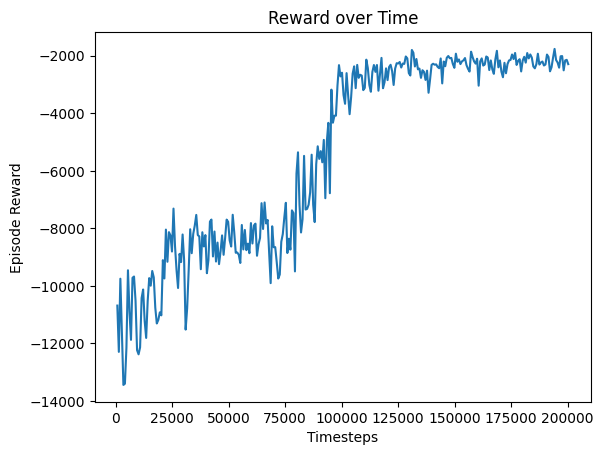

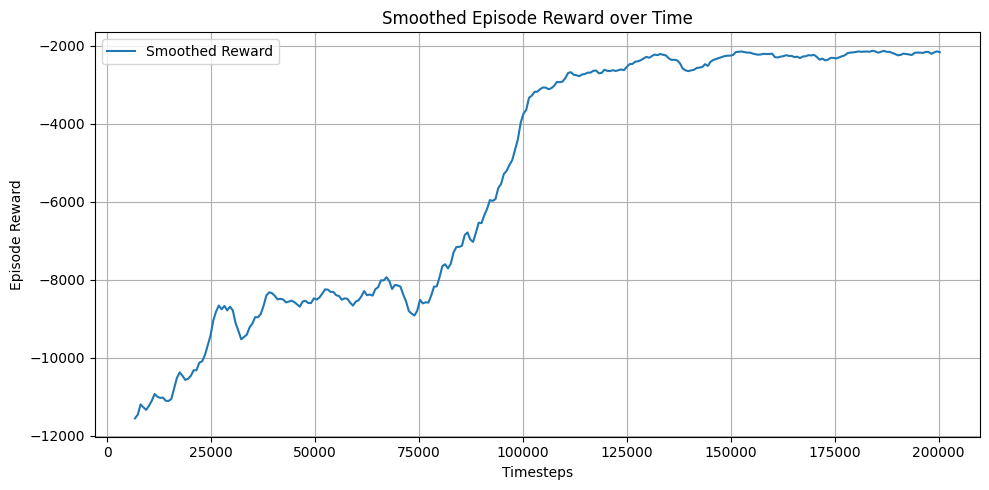

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the log
df = pd.read_csv(f'./ev2gym_logs/monitor/monitor_{num_houses}_houses.monitor.csv', skiprows=1)

plt.plot(df['l'].cumsum(), df['r'])  # l = episode length, r = episode reward
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Reward over Time")
plt.show()
df['timestep'] = df['l'].cumsum()
df['reward_smooth'] = df['r'].rolling(window=10).mean()

plt.figure(figsize=(10, 5))
plt.plot(df['timestep'], df['reward_smooth'], label='Smoothed Reward')
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Smoothed Episode Reward over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Charge as Fast As Possible
from ev2gym_driveway.baselines.heuristics import ChargeAsFastAsPossible

PROJECT_DIR = Path().resolve()
CONFIG_PATH = PROJECT_DIR / "ev2gym_driveway" / "example_config_files" / f"{num_houses}_houses_no_inflexible_loads.yaml"

# Initialize the environment
env = EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_with_future_trip,
        reward_function=reward_function_profit_and_satisfaction,
        verbose=True,  # so print_statistics works at the end
        save_statistics=True,
        # load_ev_profiles_path=Path("saved_ev_profiles/ev_profiles_3_houses.pkl"),
        statistics_filename=f"CAFAP_Statistics_{num_houses}_houses",
    )
obs = env.reset()
env._save_ev_profiles(f"saved_ev_profiles/ev_profiles_{num_houses}_houses.pkl")

# Create Agents
agent = ChargeAsFastAsPossible()  # heuristic

for t in range(env.simulation_length):
    actions = agent.get_action(env)  # get action from the agent/ algorithm
    new_state, reward, done, truncated, stats = env.step(actions)

Initializing EV2Gym environment...
[INFO] EV weekly profiles saved to saved_ev_profiles/ev_profiles_10_houses.pkl
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
CS 3 normalized actions: [1.]
CS 4 normalized actions: [1.]
CS 5 normalized actions: [1.]
CS 6 normalized actions: [1.]
CS 7 normalized actions: [1.]
CS 8 normalized actions: [1.]
CS 9 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
CS 3 normalized actions: [1.]
CS 4 normalized actions: [1.]
CS 5 normalized actions: [1.]
CS 6 normalized actions: [1.]
CS 7 normalized actions: [1.]
CS 8 normalized actions: [1.]
CS 9 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normaliz

In [14]:
# Running the trained PPO agent
# 1. Load trained model
model = PPO.load(f"ppo_ev2gym_agent_{num_houses}_houses")

# 2. Setup test env (we’ll access the raw env later)
load_ev_profiles_path=Path(f"saved_ev_profiles/ev_profiles_{num_houses}_houses.pkl"),
statistics_filename=f"PPO_Statistics_{num_houses}_houses",

def make_env(save_statistics= True):
    return EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_with_future_trip,
        reward_function=reward_function_profit_and_satisfaction,
        verbose=True,  # so print_statistics works at the end
        save_statistics=save_statistics,
        load_ev_profiles_path=Path(f"saved_ev_profiles/ev_profiles_{num_houses}_houses.pkl"),
        statistics_filename=f"PPO_Statistics_{num_houses}_houses",
    )

env_vec = DummyVecEnv([make_env])
env = env_vec.envs[0]  # unwrap raw environment for print_statistics()

# 3. Run one episode
obs = env_vec.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env_vec.step(action)
    done = done[0]  # unpack from vectorized env


Initializing EV2Gym environment...
[INFO] Loading saved EV weekly profiles from saved_ev_profiles/ev_profiles_10_houses.pkl
[INFO] Loading saved EV weekly profiles from saved_ev_profiles/ev_profiles_10_houses.pkl
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
CS 3 normalized actions: [1.]
CS 4 normalized actions: [0.65936458]
CS 5 normalized actions: [1.]
CS 6 normalized actions: [0.51137084]
CS 7 normalized actions: [1.]
CS 8 normalized actions: [1.]
CS 9 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
CS 3 normalized actions: [1.]
CS 4 normalized actions: [0.72639787]
CS 5 normalized actions: [1.]
CS 6 normalized actions: [0.49829212]
CS 7 normalized actions: [1.]
CS 8 normalized actions: [1.]
CS 9 normalized actions

In [15]:
# Load in statistics
import pickle
from dataclasses import fields
import matplotlib.pyplot as plt
import numpy as np

def load_stats(file_name: str):
    with open(file_name, "rb") as f:
        loaded_stats = pickle.load(f)

    for field in fields(loaded_stats):
        name = field.name
        value = getattr(loaded_stats, name)
        print(f"{name}: {value.shape}")
    
    return loaded_stats

In [16]:
CAFAP_Stats = load_stats(f"statistics/CAFAP_Statistics_{num_houses}_houses.pkl")
PPO_Stats = load_stats(f"statistics/PPO_Statistics_{num_houses}_houses.pkl")

cs_power_usage: (10, 672)
cs_current: (10, 672)
tr_inflexible_loads: (5, 672)
tr_overload: (5, 672)
money_spent_at_each_step: (10, 672)
money_earned_at_each_step: (10, 672)
cs_power_usage: (10, 672)
cs_current: (10, 672)
tr_inflexible_loads: (5, 672)
tr_overload: (5, 672)
money_spent_at_each_step: (10, 672)
money_earned_at_each_step: (10, 672)


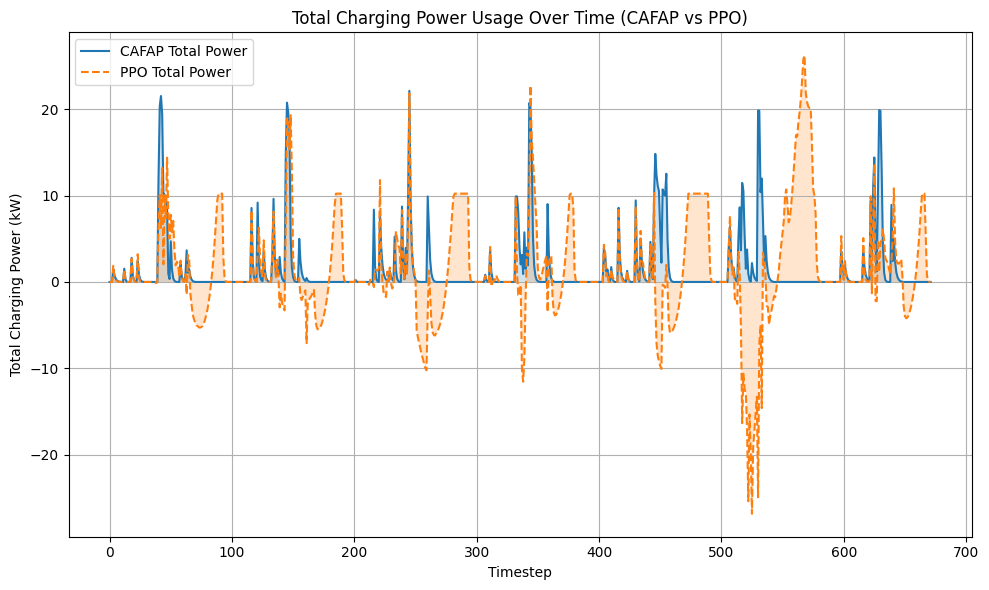

Standard Deviation:
CAFAP: 3.76, PPO: 6.22, Percent Change: 65.55%

Peak-to-Average Ratio:
CAFAP: 14.62, PPO: 17.79, Percent Change: 21.65%


In [17]:
import matplotlib.pyplot as plt
import numpy as np

timesteps = np.arange(CAFAP_Stats.cs_power_usage.shape[1])

# Sum across the EVs to get total charging power
CAFAP_total_power = np.sum(CAFAP_Stats.cs_power_usage, axis=0)
PPO_total_power = np.sum(PPO_Stats.cs_power_usage, axis=0)

plt.figure(figsize=(10,6))

plt.plot(timesteps, CAFAP_total_power, label="CAFAP Total Power", linestyle="-")
plt.plot(timesteps, PPO_total_power, label="PPO Total Power", linestyle="--")

plt.xlabel("Timestep")
plt.ylabel("Total Charging Power (kW)")
plt.title("Total Charging Power Usage Over Time (CAFAP vs PPO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.fill_between(timesteps, CAFAP_total_power, alpha=0.2)
plt.fill_between(timesteps, PPO_total_power, alpha=0.2)
plt.show()

# print("CAFAP Std Dev:", np.std(CAFAP_total_power))
# print("PPO Std Dev:", np.std(PPO_total_power))

# print("CAFAP Peak-to-Average Ratio:", np.max(CAFAP_total_power)/np.mean(CAFAP_total_power))
# print("PPO Peak-to-Average Ratio:", np.max(PPO_total_power)/np.mean(PPO_total_power))



# Compute Standard Deviation
std_cafap = np.std(CAFAP_total_power)
std_ppo = np.std(PPO_total_power)
std_diff = ((std_ppo - std_cafap) / std_cafap) * 100

# Compute Peak-to-Average Ratio
par_cafap = np.max(CAFAP_total_power) / np.mean(CAFAP_total_power)
par_ppo = np.max(PPO_total_power) / np.mean(PPO_total_power)
par_diff = ((par_ppo - par_cafap) / par_cafap) * 100


print("Standard Deviation:")
print(f"CAFAP: {std_cafap:.2f}, PPO: {std_ppo:.2f}, Percent Change: {std_diff:.2f}%\n")

print("Peak-to-Average Ratio:")
print(f"CAFAP: {par_cafap:.2f}, PPO: {par_ppo:.2f}, Percent Change: {par_diff:.2f}%")





In [18]:
# Sum across timesteps
CAFAP_money_spent = np.sum(CAFAP_Stats.money_spent_at_each_step, axis=1)  # shape (3,)
PPO_money_spent = np.sum(PPO_Stats.money_spent_at_each_step, axis=1)      # shape (3,)

CAFAP_money_spent  # shape (3,)
PPO_money_spent    # shape (3,)
total_cafap_spent = np.sum(CAFAP_money_spent)
total_ppo_spent = np.sum(PPO_money_spent)
# PPO is better if it spends *less* money
percent_savings = (total_cafap_spent - total_ppo_spent) / abs(total_cafap_spent) * 100

print(f"PPO reduces total cost by {percent_savings:.2f}% compared to CAFAP")


PPO reduces total cost by 108.33% compared to CAFAP


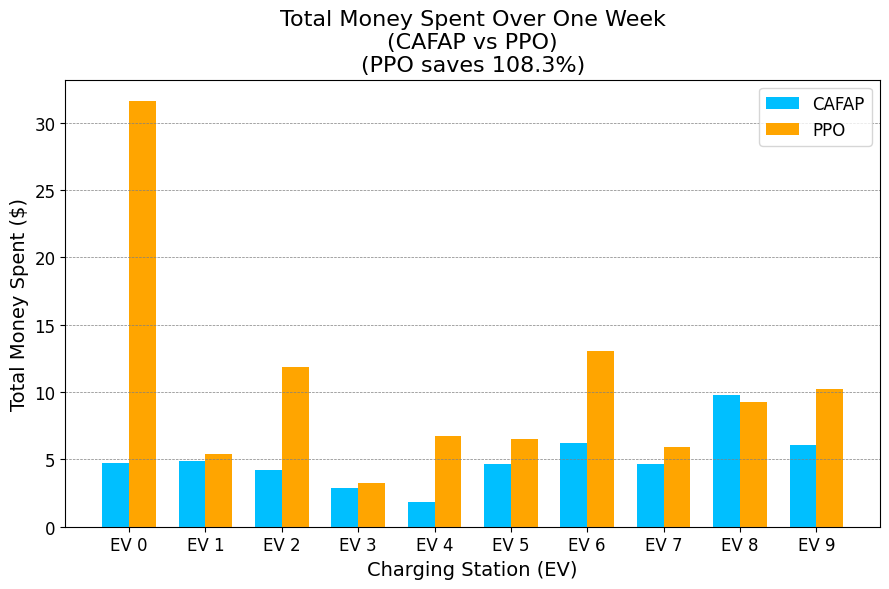

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming CAFAP_money_spent and PPO_money_spent are given

ev_ids = np.arange(len(CAFAP_money_spent))  # [0,1,2]
bar_width = 0.35

total_cafap_spent = np.sum(CAFAP_money_spent)
total_ppo_spent = np.sum(PPO_money_spent)
percent_savings = (total_cafap_spent - total_ppo_spent) / abs(total_cafap_spent) * 100

# plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(9,6))

bars1 = ax.bar(ev_ids - bar_width/2, -CAFAP_money_spent, width=bar_width, label="CAFAP", color="#00BFFF")  # deepskyblue
bars2 = ax.bar(ev_ids + bar_width/2, -PPO_money_spent, width=bar_width, label="PPO", color="#FFA500")      # orange

ax.axhline(0, color='white', linewidth=0.8)

ax.set_xlabel("Charging Station (EV)", fontsize=14)
ax.set_ylabel("Total Money Spent ($)", fontsize=14)
ax.set_title(f"Total Money Spent Over One Week\n(CAFAP vs PPO)\n(PPO saves {percent_savings:.1f}%)", fontsize=16)
ax.set_xticks(ev_ids)
ax.set_xticklabels([f"EV {i}" for i in ev_ids], fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
